In [43]:
library(tidyverse)

# Github Link
https://github.com/drv111llI/dsci100

In [44]:
url <- "https://drive.google.com/uc?id=1Vk02BWAO3Xd_unJJKj0RdpTq1ciLNPO2&export=download"
players <- read_csv(url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [45]:
distinct(players, experience)
distinct(players, subscribe)
distinct(players, gender)
players |> summarize(max(played_hours), min(played_hours), max(Age), min(Age))

experience
<chr>
Pro
Veteran
Amateur
Regular
Beginner


subscribe
<lgl>
TRUE
FALSE


gender
<chr>
Male
Female
Non-binary
Prefer not to say
Agender
Two-Spirited
Other


max(played_hours),min(played_hours),max(Age),min(Age)
<dbl>,<dbl>,<dbl>,<dbl>
223.1,0,NA,NA


# Data description

The players.csv contains information for 196 participants with 7 columns. 


### Issues with data

gender contains varied labels and phrasing; some categories appear very infrequently compared with `Male` and `Female`.

played_hours is zero-inflated and right-skewed with large outliers

hashedEmail is a anonymized unique id; name is not a unique identifier.


### Details regarding variables

experience (factor) - User competency level; one of `Amateur`, `Beginner`, `Pro`, `Regular`, `Veteran`.

subscribe (logical) - TRUE or FALSE

hashedEmail (chr) - Hashed email used as a unique user identifier.

played_hours (numeric) - Total hours played on the server; numeric

name (chr) - Player nickname on the server; may not be unique.

gender (factor) - Self-reported gender; values include `Male`, `Female`, `Non-binary`, `Prefer not to say`, `Agender`, `Two-Spirited`, `Other`.

Age (numeric) - Player age in years; numeric

## What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Broad Question

We want to identify which player characteristics and behaviours are most predictive of subscribing to the game-related newsletter.


### Specific Question

Can experience level, played hours, age, and gender predict whether a player chooses to subscribe to the newsletter?


### How the Data Help Address the Question

The dataset includes a subscription indicator (subscribe) and several potential explanatory variables (experience, played_hours, Age, gender). These variables allow us to model whether certain player characteristics are associated with newsletter subscription.

### To answer the question, we will:

Clean and prepare variables such as converting categories (experience, gender) into suitable model formats.

Use subscribe as the response variable and treat all player characteristics as explanatory variables.


# Exploratory Data Analysis and Visualization

In [55]:
players$experience <- as.factor(players$experience)

players$gender <- as.character(players$gender)
players$gender[!(players$gender %in% c("Male", "Female"))] <- "Other"
players$gender <- as.factor(players$gender)

players$subscribe <- as.logical(players$subscribe)

In [54]:
numeric_vars <- names(players)[sapply(players, is.numeric)]

mean_values <- data.frame(
  Variable = numeric_vars,
  Mean = sapply(players[numeric_vars], function(x) mean(x, na.rm = TRUE)),
  row.names = NULL
)

mean_values

Variable,Mean
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


### Plot 1: Distribution of Played Hours

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


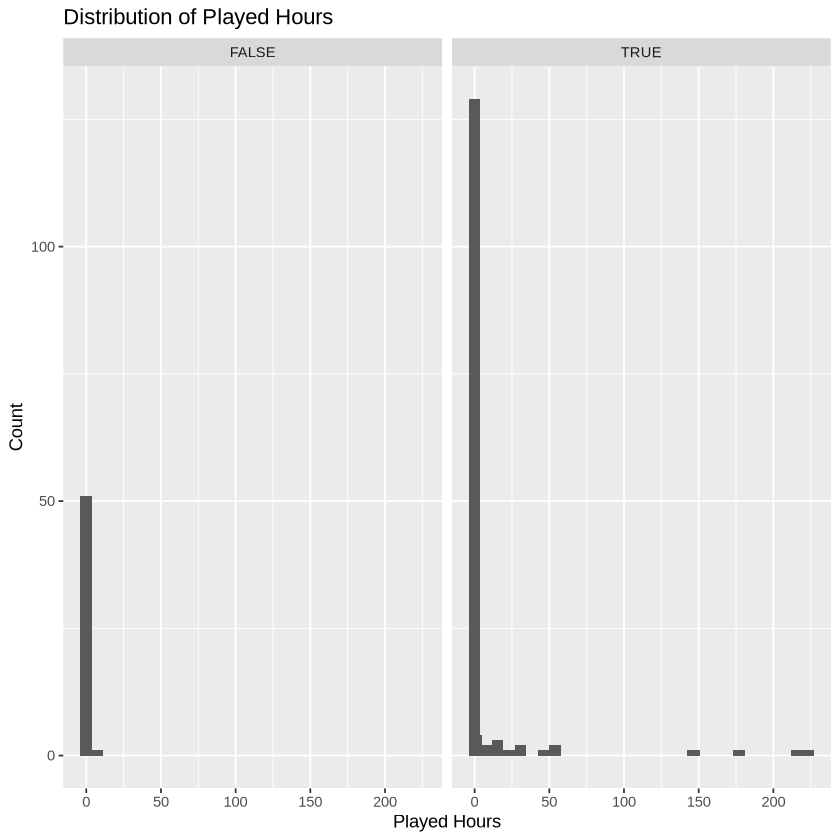

In [60]:
library(ggplot2)
ggplot(players, aes(x=played_hours)) + geom_histogram() + facet_grid(cols = vars(subscribe)) +
  geom_histogram(binwidth = 2) +
  labs(
    title = "Distribution of Played Hours",
    x = "Played Hours",
    y = "Count"
  )


### Plot 2: Subscription Rate by Experience Level

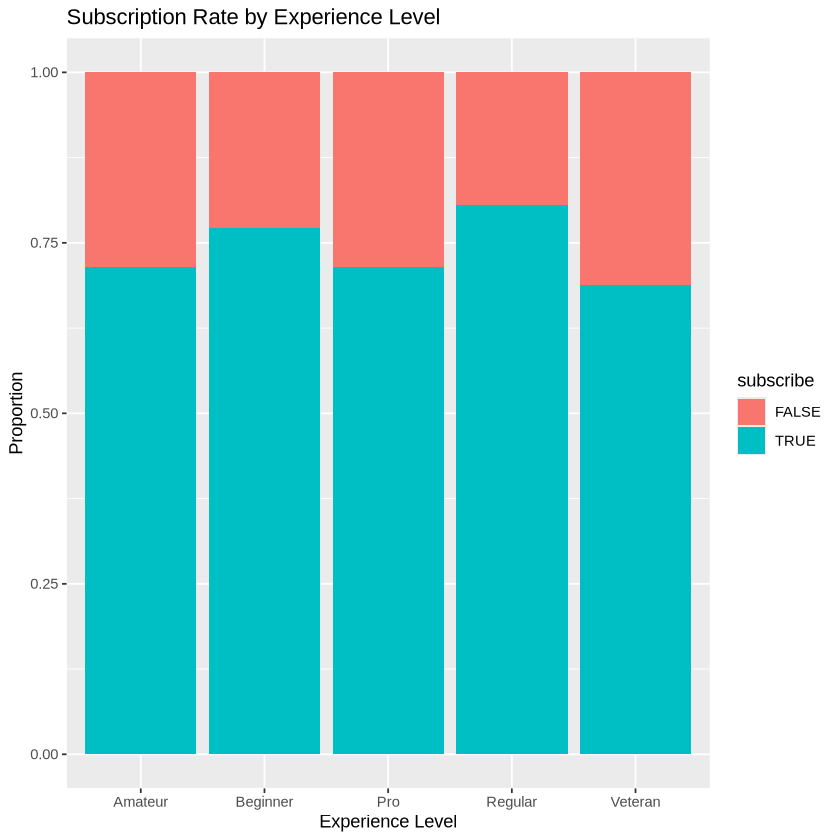

In [49]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Subscription Rate by Experience Level",
    x = "Experience Level",
    y = "Proportion"
  )


### Plot 3: Subscription Rate by Gender

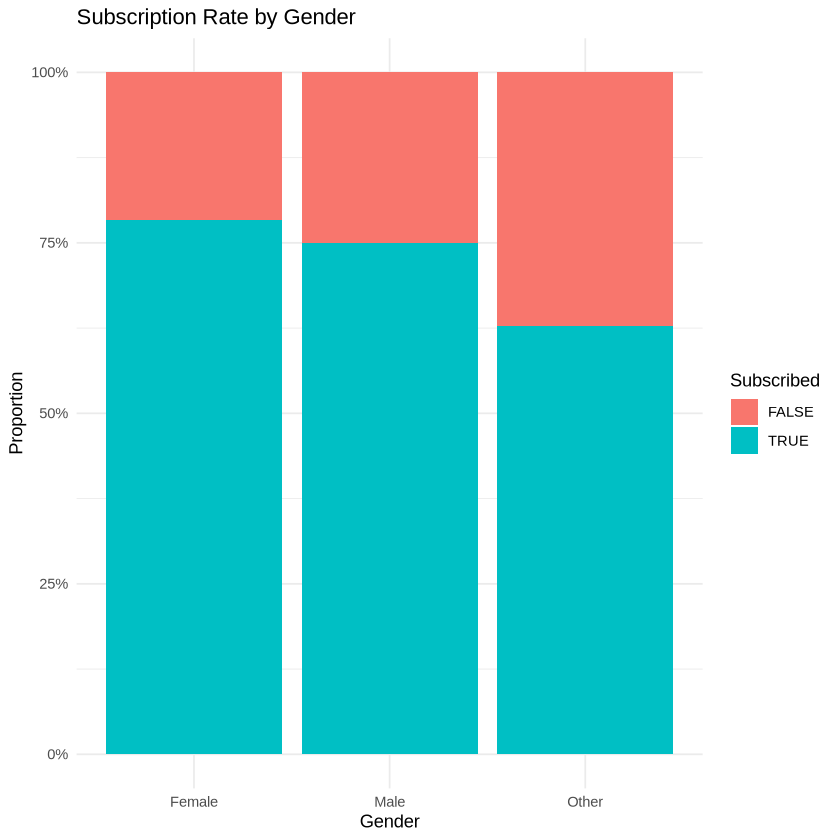

In [58]:
ggplot(players, aes(x = gender, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Subscription Rate by Gender",
    x = "Gender",
    y = "Proportion",
    fill = "Subscribed"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

### Plot 4: Age vs. Played Hours (Colored by Subscription)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


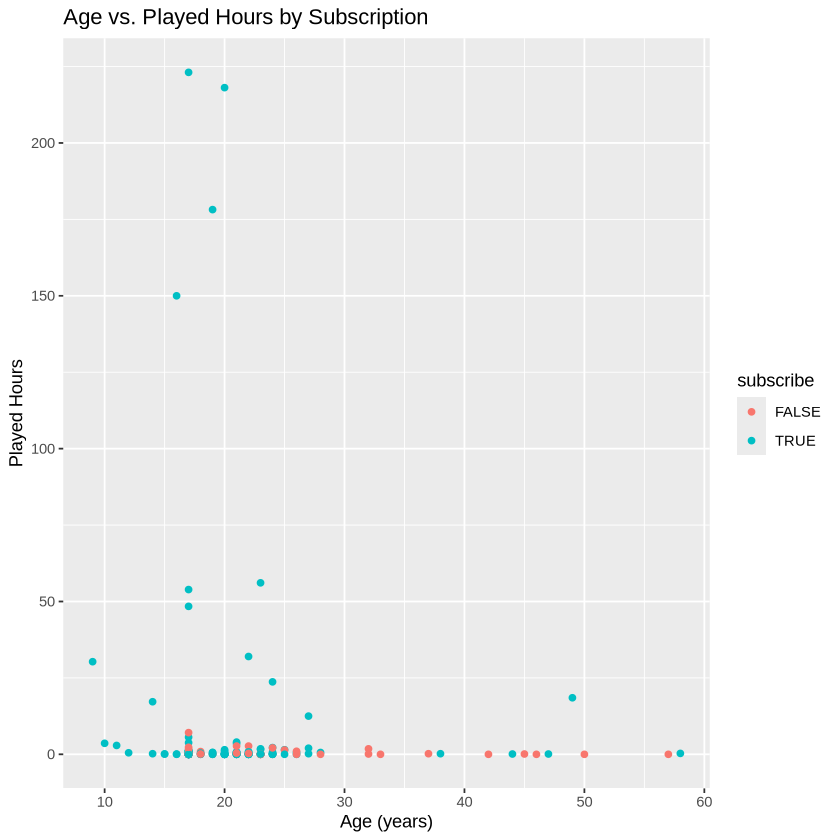

In [59]:
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(
    title = "Age vs. Played Hours by Subscription",
    x = "Age (years)",
    y = "Played Hours"
  )


### Insights

Plot 1 - Played hours show a strong right-skew, suggesting most players play lightly while a smaller group plays heavily, subscribers exhibit significantly more high-playtime outliers.

Plot 2 - Subscription proportions appear to differ across experience levels, indicating experience may be an important predictor.

Plot 3 - Male and Female players exhibit similar overall subscription patterns, while the “Other” group displays noticeably different proportions, have extremely small sample sizes and very low playtime.

Plot 4 - The scatterplot shows that players with higher playtime tend to have higher subscription likelihood, especially within older age groups.


# Methods and Plan
Proposed method We will use k-nearest neighbors (KNN) classification to predict whether a player subscribes to the newsletter. The response variable subscribe is categorical (TRUE/FALSE), making kNN suitable for this task.

### Why appropriate

KNN is simple, intuitive, and works well for categorical outcomes.

It can capture local patterns in the data without assuming a global functional form.

### Assumptions required

Observations are independent.

Predictors are scaled to comparable ranges.

The chosen distance metric meaningfully reflects similarity between players.

### Potential limitations

Sensitive to irrelevant features and outliers.

Performance depends heavily on the choice of k and distance metric.

High dimensionality (e.g., from one-hot encoding) can reduce efficiency.

### Model comparison and selection

Compare knn against at least one alternative (e.g., logistic regression or decision tree) to ensure robustness and select the model with the best balance of predictive performance and interpretability.

### Data processing plan

For the text categories like experience and gender, I’ll turn them into separate columns with 0s and 1s. This way, the computer doesn’t think “Beginner” is somehow less than “Pro” just because of a number order.

For the numbers like played_hours and Age, I’ll rescale them so they’re on a similar scale (centered around 0, with values spread evenly). This helps the algorithm compare players fairly, since otherwise hours and age might be on very different ranges.

Handle missing values (e.g., drop rows with Age = NA).